In [1]:
# imports
import os
import numpy as np
import pandas as pd
from IPython.display import Image
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten
from sklearn.utils import shuffle



Using TensorFlow backend.


In [2]:
print(os.listdir('input'))

['sample_submission.csv', 'test', 'train', 'train.csv']


In [11]:
data_dir = "input"
train_dir = data_dir + "/train/"
test_dir = data_dir + "/test/"
train_f_url = data_dir + "/train.csv"
test_f_url = data_dir + "/sample_submission.csv"
train_df = pd.read_csv(train_f_url)
test_df = pd.read_csv(test_f_url)

In [12]:
from IPython.display import Image
t_img_size = 200
Image(data=train_dir+train_df.iloc[0, 0], width=t_img_size, height=t_img_size)
print("Classification: 1 if has cactus 0 if no cactus : Value: {0}".format(train_df.iloc[0, 1]))

Classification: 1 if has cactus 0 if no cactus : Value: 1


In [13]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [14]:
train_df['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [15]:
print("Test rows {0} and columns {1}".format(test_df.shape[0], test_df.shape[1]))

Test rows 4000 and columns 2


In [16]:
print("Train rows {0} and columns {1}".format(train_df.shape[0], train_df.shape[1]))

Train rows 17500 and columns 2


In [17]:
cacti = train_df[train_df.has_cactus==1].sample(n=3, random_state=42)
not_cacti = train_df[train_df.has_cactus==0].sample(n=3, random_state=50)

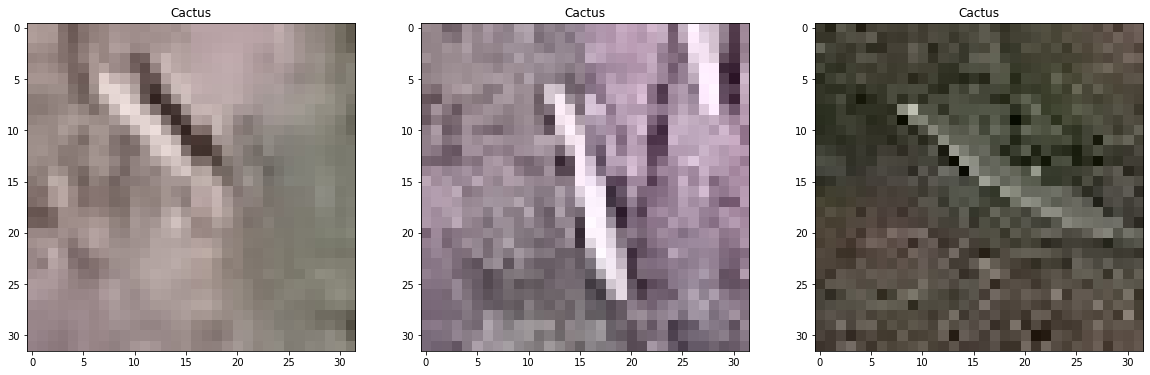

In [18]:
from PIL import Image
fig = plt.figure(1, figsize=(20, 20))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    pil_im = Image.open(train_dir + cacti.iloc[i, 0])
    im_arry = np.asarray(pil_im)
    arr = im_arry
    plt.title('Cactus')
    ax.imshow(arr)
plt.show()

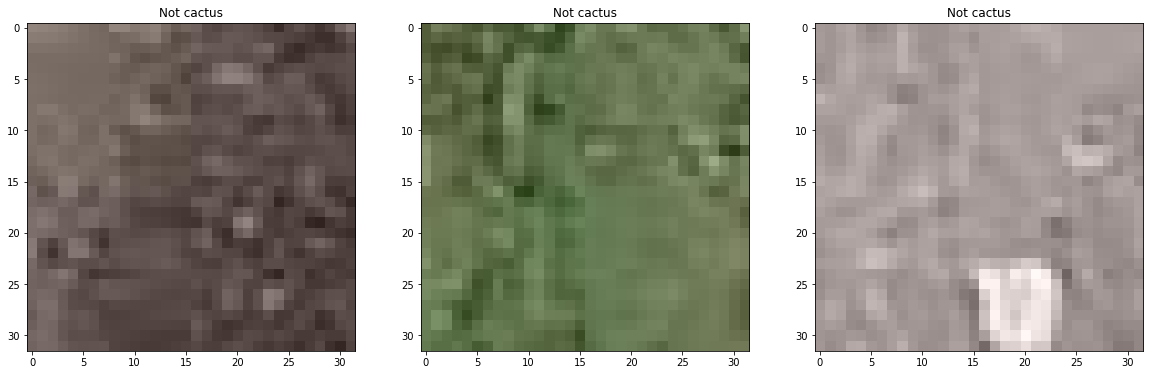

In [19]:
fig = plt.figure(1, figsize=(20, 20))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    pil_im = Image.open(train_dir + not_cacti.iloc[i, 0])
    im_arry = np.asarray(pil_im)
    arr = im_arry
    plt.title('Not cactus')
    ax.imshow(arr, cmap='viridis')
plt.show()

In [20]:
# Benchmark model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten

np.random.seed(100)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0702 08:54:11.670135 22952 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 08:54:11.737509 22952 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 08:54:11.751494 22952 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 08:54:11.777947 22952 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

In [21]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

train_df.has_cactus = train_df.has_cactus.astype(str)
train_df = shuffle(train_df)
gen = ImageDataGenerator(rescale=1./255)
len_train = len(train_df.index)
ind = int(0.70*len_train)
train_gen = gen.flow_from_dataframe(dataframe=train_df[:ind],directory=train_dir,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=100,
                                            target_size=(150,150))


val_gen = gen.flow_from_dataframe(dataframe=train_df[ind:],directory=train_dir,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=50,
                                                target_size=(150,150))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit_generator(train_gen, epochs=5, steps_per_epoch=100, validation_data=val_gen, validation_steps=50)

Found 12250 validated image filenames belonging to 2 classes.
Found 5250 validated image filenames belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 94s 938ms/step - loss: 0.1415 - acc: 0.9525 - val_loss: 0.0445 - val_acc: 0.9856
Epoch 2/5
100/100 [==============================] - 107s 1s/step - loss: 0.0637 - acc: 0.9782 - val_loss: 0.0779 - val_acc: 0.9728
Epoch 3/5
100/100 [==============================] - 110s 1s/step - loss: 0.0502 - acc: 0.9824 - val_loss: 0.0448 - val_acc: 0.9832
Epoch 4/5
100/100 [==============================] - 110s 1s/step - loss: 0.0482 - acc: 0.9818 - val_loss: 0.0645 - val_acc: 0.9740
Epoch 5/5
100/100 [==============================] - 108s 1s/step - loss: 0.0448 - acc: 0.9831 - val_loss: 0.1019 - val_acc: 0.9648


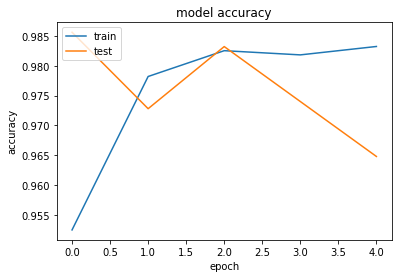

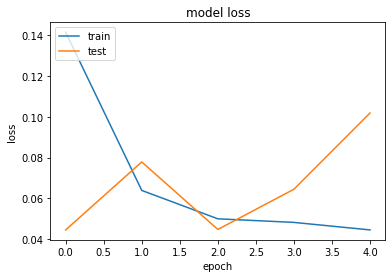

In [24]:
plot_history(history)